## Pre-Trained DistilRoBERTa Model

The code below loads a DistilRoBERTa model pre-trained on 500k pairs of human and AI-generated sequences from the SlimPajama Dataset. These pairs were generated by [Guanshuo Xu](https://www.kaggle.com/wowfattie) using multiple language models, providing a diverse set of data for pre-training.

### Note
Scripts for downloading the large dataset and pre-training the downloaded model will be added to this repository soon.

In [1]:
# Import necessary libraries
import zipfile
import gdown
import os

# Define the path of the zip file and the output folder
zip_file_path = './train_df.csv.zip'
output_folder = './'

# Check if the file doesn't exist
if not os.path.exists('./train_df.csv'):
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files in the zip file to the output folder
        zip_ref.extractall(output_folder)

# Define the URL of the pre-trained model saved in Google Drive
url = 'https://drive.google.com/file/d/1adWdMpKwoM-1PPzDMulcpxapO0uIvkRq/view?usp=drive_link'

# Define the output path for the downloaded file
output = './weights/weights_ep0'

# Check if the file doesn't exist
if not os.path.exists(output):
    # Download the file from the URL and save it to the output path
    gdown.download(url, output, quiet=False)

# Loading the datasets:

In [2]:
import os
from datasets import load_dataset

class DatasetPreprocessor:
    def __init__(self, path_raw_data, test_size=0.1, seed=1):
        self.path_raw_data = path_raw_data
        self.test_size = test_size
        self.seed = seed

    def load_and_preprocess(self):
        if not os.path.exists(self.path_raw_data):
            raise FileNotFoundError(f"{self.path_raw_data} does not exist.")
        
        dataset = load_dataset("csv", data_files=[self.path_raw_data], split='train')
        dataset = self.class_encode(dataset)
        dataset = self.split_dataset(dataset)
        dataset = self.clean_and_count(dataset)
        
        return dataset

    @staticmethod
    def class_encode(dataset):
        return dataset.class_encode_column("label")

    def split_dataset(self, dataset):
        return dataset.train_test_split(test_size=self.test_size, stratify_by_column="label", seed=self.seed)

    @staticmethod
    def clean_and_count(dataset):
        def clean_and_count_words_per_essay(example):
            example["text"] = [x.strip('\n') for x in example["text"]]
            example["Words Per Essay"] = [len(x.split()) for x in example["text"]]
            return example

        return dataset.map(clean_and_count_words_per_essay, batched=True)

In [3]:

path_raw_data = './train_df.csv'
preprocessor = DatasetPreprocessor(path_raw_data)
dataset = preprocessor.load_and_preprocess()
dataset

Using custom data configuration default-ee603433bed49286


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Parameter 'function'=<function Dataset.class_encode_column.<locals>.stringify_column at 0x7f6252d35820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ee603433bed49286/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


Stringifying the column:   0%|          | 0/28 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/28 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay'],
        num_rows: 2735
    })
})

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_dataset(dataset):
    try:
        # Set the dataset format to pandas
        dataset.set_format(type='pandas')

        # Get the training data
        df = dataset['train'][:]

        # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        # Customize the figure background color
        fig.patch.set_facecolor('white')

        # Plot the frequency of classes on the first subplot
        df["label"].value_counts(ascending=True).plot(kind='barh', ax=axs[0], color='skyblue', edgecolor='black')

        # Customize the first subplot
        axs[0].set_title("Frequency of Classes", fontsize=14)
        axs[0].set_xlabel('Frequency', fontsize=12)
        axs[0].set_ylabel('Class', fontsize=12)
        axs[0].grid(axis='x', linestyle='--', alpha=0.6)

        # Plot the boxplot of words per essay on the second subplot
        df.boxplot("Words Per Essay", by="label", grid=False, showfliers=False, color=dict(boxes='black', whiskers='black', medians='blue', caps='gray'), ax=axs[1])

        # Customize the second subplot
        axs[1].set_title('Words Per Essay by Label', fontsize=14)
        axs[1].set_xlabel('Label', fontsize=12)
        axs[1].set_ylabel('Words Per Essay', fontsize=12)
        axs[1].grid(axis='y', linestyle='--', alpha=0.6)

        # Display the figure
        plt.tight_layout()
        plt.show()

    except pd.errors.EmptyDataError:
        print("The dataset is empty.")
    except KeyError as e:
        print(f"The dataset does not contain a necessary column: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

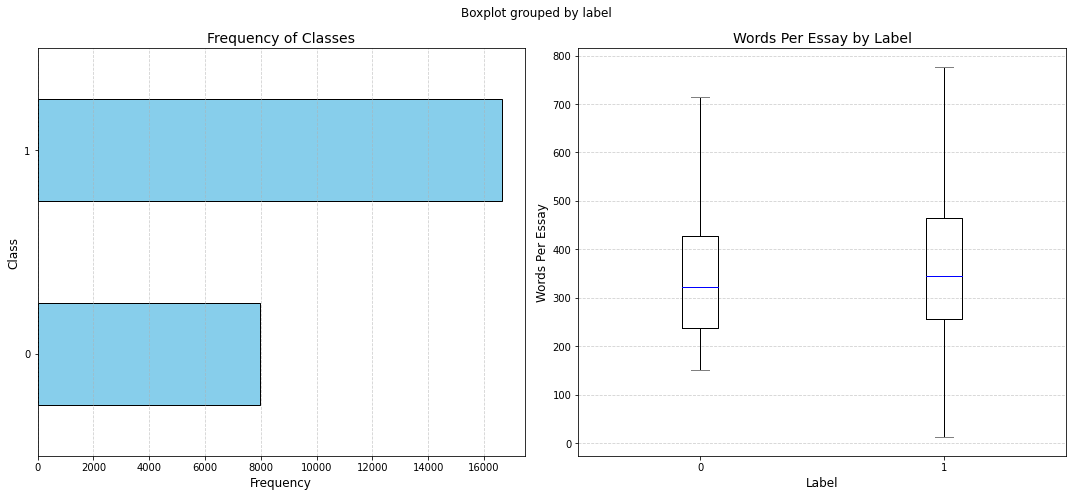

In [5]:
# Call the function with the dataset
plot_dataset(dataset)

# From Text to Tokens:

In [6]:
from transformers import AutoTokenizer

def tokenize_text(dataset, model_path, max_length, batch_size):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Reset the format of the dataset
    dataset.reset_format()

    # Define the tokenization function
    def tokenize(batch):
        return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=max_length)

    # Apply the tokenization function to the dataset
    dataset_encoded = dataset.map(tokenize, batched=True, batch_size=batch_size)

    return dataset_encoded


In [7]:
# Define the arguments
dataset = dataset
model_path = "distilroberta-base"
max_length = 256
batch_size = 200

# Call the function with the arguments
dataset_encoded = tokenize_text(dataset, model_path, max_length, batch_size)
dataset_encoded

  0%|          | 0/124 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'attention_mask'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'attention_mask'],
        num_rows: 2735
    })
})

# Training a Baseline Text Classifier:

#### Vizualise Features Extracted by the Model:

In [8]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig, AutoTokenizer

class DAIGTModel(nn.Module):
    def __init__(self, model_path, config, tokenizer, pretrained=False):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_path, config=config)
        else:
            self.model = AutoModel.from_config(config)
        self.classifier = nn.Linear(config.hidden_size, 1)   
    def forward_features(self, input_ids, attention_mask=None):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        embeddings = sum_embeddings / sum_mask
        return embeddings
    def forward(self, input_ids, attention_mask):
        embeddings = self.forward_features(input_ids, attention_mask)
        logits = self.classifier(embeddings)
        return logits

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = DAIGTModel(model_path, config, tokenizer, pretrained=True)
# Load weights from the custom pretrained model
model.load_state_dict(torch.load('./weights/weights_ep0'))
model.to(device)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


UnpicklingError: invalid load key, '<'.

In [20]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    encoder_block = model.model
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = encoder_block(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
# Our model expects torch tensors as input
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_hidden = dataset_encoded.map(
                                          extract_hidden_states,
                                          batched=True,
                                          batch_size=16
                                     )

dataset_hidden

In [24]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_encoded["train"]["label"])
y_valid = np.array(dataset_encoded["test"]["label"])
X_train.shape, X_valid.shape

((24615, 768), (2735, 768))

In [25]:
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

In [26]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,2.128312,5.061209,1
1,-2.660075,-3.218323,1
2,11.283067,-2.775222,1
3,-1.554991,1.739172,1
4,-0.816827,4.781367,1


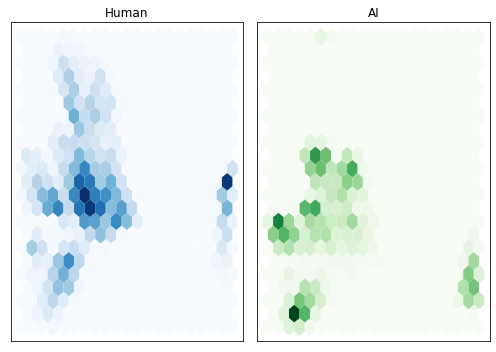

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Blues", "Greens"]
labels = ["Human", "AI"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training a simple baseline classifier:

In [28]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8658135283363803

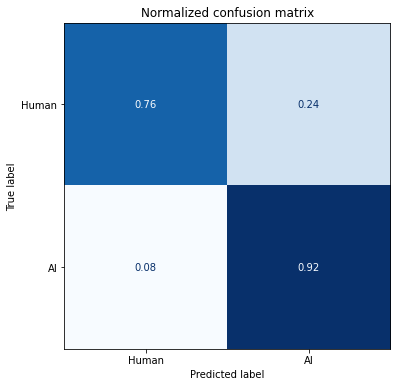

In [29]:
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
y_preds_proba = lr_clf.predict_proba(X_valid)[:,-1]
plot_confusion_matrix(y_preds, y_valid, labels)

In [30]:
print(classification_report(y_valid, y_preds))
print("roc auc score:", roc_auc_score(y_valid, y_preds_proba))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       887
           1       0.89      0.92      0.90      1848

    accuracy                           0.87      2735
   macro avg       0.85      0.84      0.84      2735
weighted avg       0.86      0.87      0.86      2735

roc auc score: 0.9257962537274826


# Fine-tuning a transformers model:

In [40]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch
import random
import pickle
from torch.cuda.amp import autocast, GradScaler
import time
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
import copy
import re

In [41]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [42]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class DAIGTDataset(Dataset):
    def __init__(self, text_list, tokenizer, max_len, label_list):
        self.text_list=text_list
        self.tokenizer=tokenizer
        self.max_len=max_len
        self.label_list=label_list
    def __len__(self):
        return len(self.text_list)
    def __getitem__(self, index):
        text = self.text_list[index]
        label = self.label_list[index]
        tokenized = self.tokenizer(text=text,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=self.max_len,
                                   return_tensors='pt')
        return tokenized['input_ids'].squeeze(), tokenized['attention_mask'].squeeze(), label

In [43]:
learning_rate = 1e-5
max_len = 512
batch_size = 10
num_epoch = 1

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_train_steps = int(len(dataset_encoded['train'])/(batch_size*3)*num_epoch)

In [44]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

In [45]:
dataset_encoded.set_format("pandas")

In [46]:
# training
text_list = dataset_encoded['train']['text'].tolist()
label_list = dataset_encoded['train']['label'].tolist()

train_datagen = DAIGTDataset(text_list, tokenizer, max_len, label_list)
train_generator = DataLoader(dataset=train_datagen,
                             batch_size=batch_size,
                             pin_memory=False)

start_time = time.time()

scaler = GradScaler()
for ep in range(num_epoch):
    losses = AverageMeter()
    model.train()

    #progress_bar = tqdm(range(len(train_generator)))

    for j, (batch_input_ids, batch_attention_mask, batch_labels) in enumerate(train_generator):
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.float().to(device)

        with autocast():
            logits = model(batch_input_ids, batch_attention_mask)
            loss = nn.BCEWithLogitsLoss()(logits.view(-1), batch_labels)

        losses.update(loss.item(), batch_input_ids.size(0))

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        #progress_bar.update(1)
        print('\r',end='',flush=True)
        message = '%s %5.1f %6.1f    |     %0.3f     |' % ("train",j/len(train_generator)+ep,ep,losses.avg)
        print(message , end='',flush=True)

    
    print('epoch: {}, train_loss: {}'.format(ep, losses.avg), flush=True)

out_dir = 'output_weights/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
torch.save(model.state_dict(), out_dir+'weights_ft_ep{}'.format(ep))

end_time = time.time()
print(end_time-start_time)

train   0.0    0.0    |     2.241     |

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train   1.0    0.0    |     0.263     |epoch: 0, train_loss: 0.263160145451265
298.9556350708008


In [54]:
# Evaluate model
text_list = dataset_encoded['test']['text'].tolist()
label_list = dataset_encoded['test']['label'].tolist()

model.eval()

test_datagen = DAIGTDataset(text_list, tokenizer, max_len, label_list)
test_generator = DataLoader(dataset=test_datagen,
                            batch_size=batch_size,
                            shuffle=False,
                            pin_memory=False)

pred_prob = np.zeros((len(text_list), ), dtype=np.float32)

for j, (batch_input_ids, batch_attention_mask, batch_label) in tqdm(enumerate(test_generator), total=len(test_generator)):
    with torch.no_grad():
        start = j*batch_size
        end = start+batch_size
        if j == len(test_generator)-1:
            end = len(test_generator.dataset)
        batch_input_ids = batch_input_ids.cuda()
        batch_attention_mask = batch_attention_mask.cuda()
        with autocast():
            logits = model(batch_input_ids, batch_attention_mask)            
        pred_prob[start:end] = logits.sigmoid().cpu().data.numpy().squeeze()
        
pred_labels = np.where(pred_prob > 0.5, 1, 0)


100%|██████████| 274/274 [00:11<00:00, 23.49it/s]


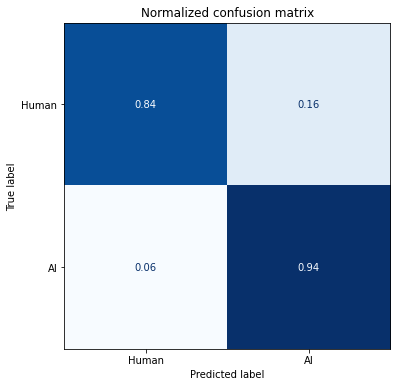

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       887
           1       0.92      0.94      0.93      1848

    accuracy                           0.91      2735
   macro avg       0.90      0.89      0.89      2735
weighted avg       0.91      0.91      0.91      2735

roc auc score: 0.9606262536786777


In [55]:
plot_confusion_matrix(pred_labels, label_list, labels)
print(classification_report(label_list, pred_labels))
print("roc auc score:", roc_auc_score(label_list, pred_prob))

#### Visualizing hidden states after the model has been finetuned:

In [59]:
# Our model expects torch tensors as input
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_hidden = dataset_encoded.map(
                                          extract_hidden_states,
                                          batched=True,
                                          batch_size=16
                                     )

dataset_hidden

  0%|          | 0/1539 [00:00<?, ?ba/s]

  0%|          | 0/171 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2735
    })
})

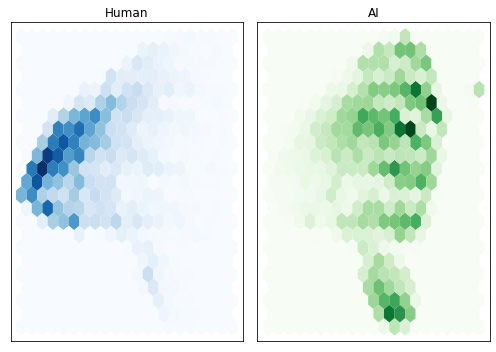

CPU times: user 1min 27s, sys: 2.87 s, total: 1min 30s
Wall time: 17.7 s


In [60]:
%%time

X_train = np.array(dataset_hidden["train"]["hidden_state"])
y_train = np.array(dataset_encoded["train"]["label"])
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Blues", "Greens"]
labels = ["Human", "AI"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

# Playing a little bit with the model:

In [ ]:
label_list = [0] # just a placeholder

In [ ]:
def pred_if_ai_generated(text_list, label_list):
    model.eval()

    test_datagen = DAIGTDataset(text_list, tokenizer, max_len, label_list)
    test_generator = DataLoader(dataset=test_datagen,
                                batch_size=batch_size,
                                shuffle=False,
                                pin_memory=False)

    pred_prob = np.zeros((len(text_list), ), dtype=np.float32)

    for j, (batch_input_ids, batch_attention_mask, __) in enumerate(test_generator):
        with torch.no_grad():
            start = j*batch_size
            end = start+batch_size
            if j == len(test_generator)-1:
                end = len(test_generator.dataset)
            batch_input_ids = batch_input_ids.cuda()
            batch_attention_mask = batch_attention_mask.cuda()
            with autocast():
                logits = model(batch_input_ids, batch_attention_mask)            
            pred_prob[start:end] = logits.sigmoid().cpu().data.numpy().squeeze()

    pred_labels = np.where(pred_prob > 0.5, 1, 0)
    
    
    print(f"Probability of being generated by AI = {pred_prob.item():.2%}")

In [147]:
text_list = ["""
A positive attitude is often considered a key to success in life. Various experiments and scientific studies have supported the idea that positivity can significantly impact life outcomes. Most people who are successful attribute their happiness and achievements to a positive mindset. This positive approach reduces stress and enhances productivity, as the brain and body are intrinsically connected.

However, there is a portion of the population that feels stuck in life due to negative thinking. They believe that life's challenges are not easily overcome by positivity alone. This perspective highlights the difficulty some people face in adopting a positive outlook, despite its potential benefits.

One practical example of the power of positivity is evident in situations like facing a challenging test. A student who approaches the test with confidence and a belief in their preparation is more likely to succeed. This demonstrates how a positive mindset can transform difficult tasks into achievable goals, showcasing the remarkable capabilities of the human brain.

In essence, cultivating a positive attitude is crucial for achieving success and maintaining a healthy mind and body. By consciously shifting from negative to positive thinking, individuals can improve their own lives and positively influence those around them. It's not just about facing difficulties but transforming them into opportunities for growth and success. Thinking positively, even in the face of challenges, can lead to better health and a more fulfilling life.
"""]

In [148]:
pred_if_ai_generated(text_list, label_list)

Probability of being generated by AI = 90.33%
